## 1. Python librairies

In [2]:
import datetime
import io
import json
import math
import matplotlib.pyplot as plt
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes import SearchIndexerClient
from azure.search.documents.models import Vector
from azure.search.documents.indexes.models import (
    SearchIndexerDataContainer,
    SearchIndexerDataSourceConnection,
)

from azure.storage.blob import BlobServiceClient

In [3]:
sys.version

'3.9.6 (default, May  7 2023, 23:32:45) \n[Clang 14.0.3 (clang-1403.0.22.14.1)]'

In [4]:
print("Today is", datetime.datetime.today())

Today is 2023-12-23 02:13:35.283326


## 2. Azure AI Services

In [5]:
load_dotenv("azure.env")

# Azure Computer Vision 4
acv_key = os.getenv("acv_key")
acv_endpoint = os.getenv("acv_endpoint")

# Azure Cognitive Search
acs_endpoint = os.getenv("acs_endpoint")
acs_key = os.getenv("acs_key")

In [6]:
if acv_endpoint.endswith("/"):
    acv_endpoint = acv_endpoint[:-1]

if acs_endpoint.endswith("/"):
    acs_endpoint = acv_endpoint[:-1]

## 3. Functions & parameters

In [7]:
index_name = "fashion-demo"

api_version = "2023-02-01-preview"

In [8]:
def text_embedding(prompt):
    """
    Text embedding using Azure Computer Vision 4.0
    """
    version = "?api-version=" + api_version + "&modelVersion=latest"
    vec_txt_url = f"{acv_endpoint}/computervision/retrieval:vectorizeText{version}"
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    payload = {"text": prompt}
    response = requests.post(vec_txt_url, json=payload, headers=headers)

    if response.status_code == 200:
        text_emb = response.json().get("vector")
        return text_emb

    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [9]:
session = requests.Session()


def image_embedding(imagefile):
    version = "?api-version=" + api_version + "&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": acv_key,
    }

    try:
        blob_service_client = BlobServiceClient.from_connection_string(
            blob_connection_string
        )
        container_client = blob_service_client.get_container_client(container_name)

        blob_client = container_client.get_blob_client(imagefile)
        stream = BytesIO()
        blob_data = blob_client.download_blob()
        blob_data.readinto(stream)

        stream.seek(0)  

        response = session.post(vec_img_url, data=stream, headers=headers)
        response.raise_for_status()  

        image_emb = response.json()["vector"]
        return image_emb

    except requests.exceptions.RequestException as e:
        print(f"Request Exception: {e}")
    except Exception as ex:
        print(f"Error: {ex}")

    return None

In [10]:
def get_cosine_similarity(vector1, vector2):
    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return cosine_similarity

In [11]:
def url_image_embedding(image_url):
    url = f"{acv_endpoint}/computervision/retrieval:vectorizeImage"
    params = {"api-version": api_version}
    headers = {"Content-Type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}
    data = {"url": image_url}

    try:
        response = requests.post(url, params=params, headers=headers, json=data)
        response.raise_for_status()  # Raise an exception for non-2xx status codes
        embeddings = response.json()["vector"]
        return embeddings

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

In [12]:
def prompt_search(prompt, topn=5, disp=False):
    results_list = []

    search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))

    vector = Vector(value=text_embedding(prompt), k=topn, fields="imagevector")
    response = search_client.search(
        search_text=prompt, vector=vector, select=["idfile", "imagefile"]
    )
    print("\033[1;31;34m")
    print("Finding images using prompt =", prompt, "\n")

    for nb, result in enumerate(response, 1):
        image_file = result["imagefile"]
        results_list.append(image_file)
        if disp:
            print(f"Top {nb:02} : {image_file}")

    return results_list

In [13]:
def image_search(image_url, topn=5, disp=False):
    results_list = []

    search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))

    response = search_client.search(
        search_text="",
        vector=Vector(
            value=url_image_embedding(image_url), k=topn, fields="imagevector"
        ),
        select=["idfile", "imagefile"],
    )

    print("\033[1;31;34m")
    print("Reference image:", image_url)
    image_ref = Image.open(BytesIO(requests.get(image_url).content))
    image_ref.thumbnail((360, 360), Image.LANCZOS)
    display(image_ref)
    print("\033[1;31;34m")

    for nb, result in enumerate(response, 1):
        image_file = result["imagefile"]
        results_list.append(image_file)
        if disp:
            print("Top", nb, ":", image_file)

    return results_list

In [14]:
def display_images(images_list, num_cols=5, disp_cosine=False, source="prompt"):
    num_images = len(images_list)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

    if disp_cosine and source == "prompt":
        cos_list = [
            get_cosine_similarity(text_embedding(prompt), image_embedding(image))
            for image in images_list
        ]

    if disp_cosine and source == "image":
        cos_list = [
            get_cosine_similarity(
                url_image_embedding(image_url), image_embedding(image)
            )
            for image in images_list
        ]

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            blob_client = container_client.get_blob_client(images_list[idx])
            blob_image = blob_client.download_blob().readall()
            ax.axis("off")
            # Display image
            image = Image.open(io.BytesIO(blob_image))
            ax.imshow(image)
            topnid = idx + 1
            title = f"Top {topnid:02}\n{images_list[idx]}"

            if disp_cosine:
                title += f"\nCosine similarity = {round(cos_list[idx], 5)}"
            ax.set_title(title)

        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
def index_stats(index_name):
    url = (
        acs_endpoint
        + "/indexes/"
        + index_name
        + "/stats?api-version=2021-04-30-Preview"
    )
    headers = {
        "Content-Type": "application/json",
        "api-key": acs_key,
    }
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))

    else:
        print("Request failed with status code:", response.status_code)

In [16]:
def index_status(index_name):
    print("Azure Cognitive Search Index:", index_name, "\n")

    headers = {"Content-Type": "application/json", "api-key": acs_key}
    params = {"api-version": "2021-04-30-Preview"}
    index_status = requests.get(
        acs_endpoint + "/indexes/" + index_name, headers=headers, params=params
    )
    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("Request failed")

In [17]:
EMBEDDINGS_DIR = "embeddings"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

In [18]:
blob_connection_string = os.getenv("blob_connection_string")
container_name = os.getenv("container_name")

In [21]:
ds_client = SearchIndexerClient(acs_endpoint, AzureKeyCredential(acs_key))
container = SearchIndexerDataContainer(name=container_name)
data_source_connection = SearchIndexerDataSourceConnection(
    name=f"{index_name}-blob",
    type="azureblob",
    connection_string=blob_connection_string,
    container=container,
)
data_source = ds_client.create_or_update_data_source_connection(data_source_connection)

In [22]:
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs()

first_blob = next(blobs)
blob_url = container_client.get_blob_client(first_blob).url

In [23]:
list_of_images = container_client.list_blobs()

images_list = []

for image in list_of_images:
    imagefile = image["name"]
    images_list.append(imagefile)

In [24]:
print("Number of catalog images =", len(images_list))

Number of catalog images = 25880


## 4. Azure Cognitive Search

In [25]:
try:
    print("Setting the Azure Cognitive Search client")
    search_client = SearchIndexClient(
        endpoint=acs_endpoint, credential=AzureKeyCredential(acs_key)
    )
    print("Done")
    print(search_client)

except:
    print("Request failed. Cannot create Azure Cognitive Search client:", acs_endpoint)

Setting the Azure Cognitive Search client
Done


### Azure Cognitive Search index status

In [26]:
index_stats(index_name)

Azure Cognitive Search index status for: fashion-demo 

{
  "@odata.context": "https://mono-cognitive-search.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 25879,
  "storageSize": 394790772
}


In [27]:
index_status(index_name)

Azure Cognitive Search Index: fashion-demo 

{
     "@odata.context": "https://mono-cognitive-search.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DC02877B219591\"",
     "name": "fashion-demo",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "idfile",
               "type": "Edm.String",
               "searchable": false,
               "filterable": false,
               "retrievable": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "imagefile",
               "type": "Edm.String",
               "searchable": true,
               "filterable": false,
               "retrievable": true,
               "sortable": false,
               "facet

### Quick test on a basic text search

In [28]:
search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))

text = "8683522157586"
print("Let's query the index with text =", text, "\n")

response = search_client.search(search_text=text)

for result in response:
    print("Id file:", result["idfile"])
    print("Filename:", result["imagefile"])
    print("Vector embedding size:", len(result["imagevector"]))

Let's query the index with text = 8683522157586 

Id file: 7066
Filename: 8683522157586.jpg
Vector embedding size: 1024


## 5. Visual Search using a prompt


Finding images using prompt = A red dress 



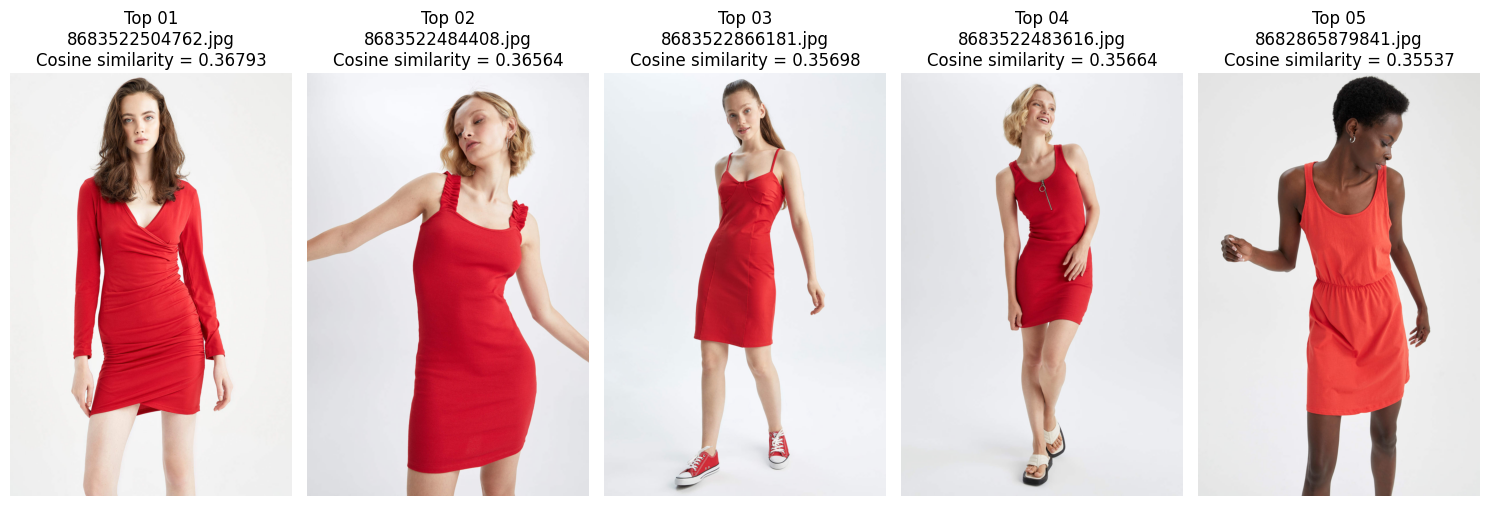

In [29]:
prompt = "A red dress"

images = prompt_search(prompt, topn=5)
display_images(images, disp_cosine=True, source="prompt")

## 6. Visual search using an image

In [30]:
image_url = "https://github.com/retkowsky/images/blob/master/visualsearch%20(4).jpg?raw=true"


Reference image: https://github.com/retkowsky/images/blob/master/visualsearch%20(4).jpg?raw=true


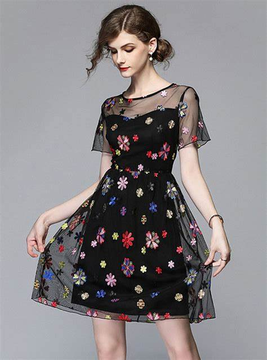

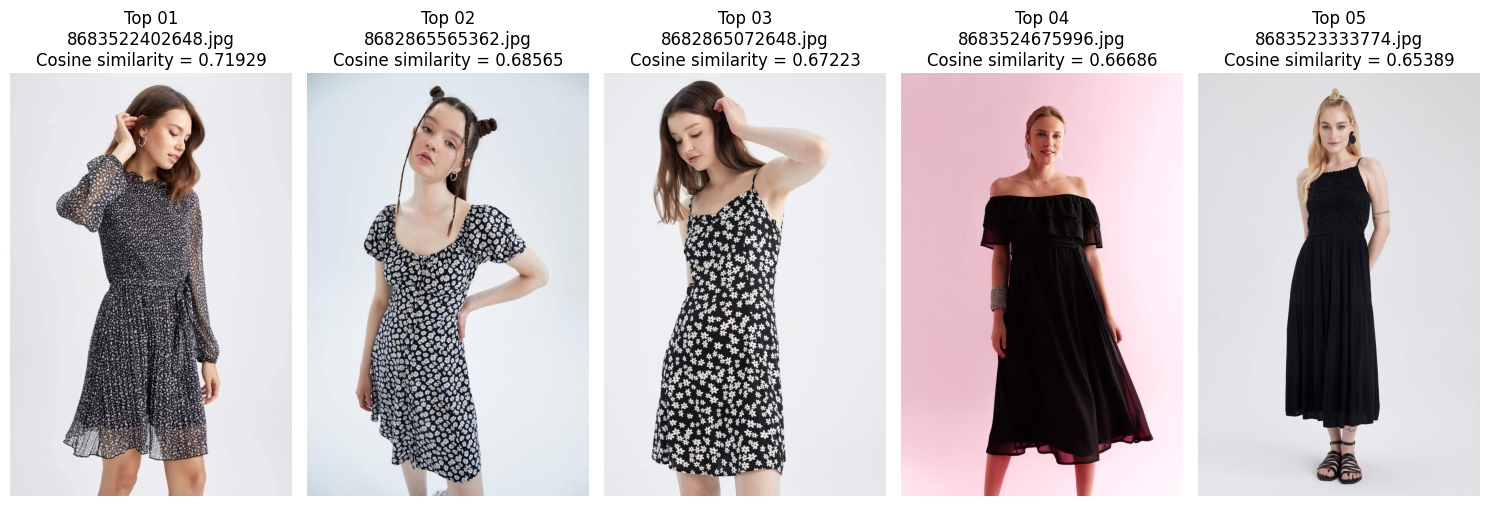

In [31]:
images = image_search(image_url, disp=False, topn=5)
display_images(images, disp_cosine=True, source="image")